In [1]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()

Saving insurance_data.csv to insurance_data.csv


In [2]:
df = pd.read_csv(io.BytesIO(next(iter(uploaded.values()))))
df.head()

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,3,4,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,4,5,NaN,male,34.1,100,No,0,No,northwest,1137.01


shape: (1340, 11)
index              int64
PatientID          int64
age              float64
gender            object
bmi              float64
bloodpressure      int64
diabetic          object
children           int64
smoker            object
region            object
claim            float64
dtype: object
missing:
 index            0
PatientID        0
age              5
gender           0
bmi              0
bloodpressure    0
diabetic         0
children         0
smoker           0
region           0
claim            0
dtype: int64
count     1340.000000
mean     13252.745642
std      12109.609288
min       1121.870000
25%       4719.685000
50%       9369.615000
75%      16604.305000
max      63770.430000
Name: claim, dtype: float64


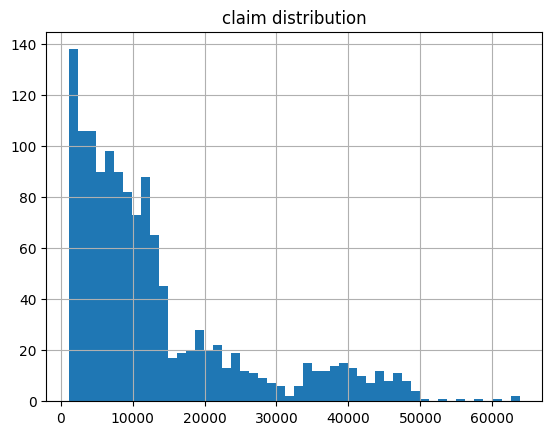

In [6]:
print("shape:", df.shape)
print(df.dtypes)
print("missing:\n", df.isnull().sum())
print(df['claim'].describe())   # if 'claim' is your target

# simple plot
import matplotlib.pyplot as plt
df['claim'].hist(bins=50)
plt.title('claim distribution')
plt.show()


In [7]:
# drop common ID cols if present
for c in ['index','PatientID']:
    if c in df.columns:
        df = df.drop(columns=[c])

y = df['claim']                  # target
X = df.drop(columns=['claim'])   # features

# infer numeric / categorical automatically
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

print("numeric:", numeric_features)
print("categorical:", categorical_features)


numeric: ['age', 'bmi', 'bloodpressure', 'children']
categorical: ['gender', 'diabetic', 'smoker', 'region']


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, categorical_features)
])


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

rfr = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', rfr)
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'bloodpressure',
                                                   'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'diabetic',
                                                   'smoker', 'region'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")


MAE: 4067.93, RMSE: 5454.71, R2: 0.819


In [13]:
# get OHE column names safely
ohe = pipeline.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
try:
    ohe_cols = ohe.get_feature_names_out(categorical_features)
except:
    ohe_cols = ohe.get_feature_names(categorical_features)

feature_names = numeric_features + list(ohe_cols)
importances = pipeline.named_steps['model'].feature_importances_
import pandas as pd
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp.head(15))


smoker_Yes          0.335081
smoker_No           0.267652
bmi                 0.209030
bloodpressure       0.084472
age                 0.046056
children            0.018562
region_northeast    0.009802
region_northwest    0.005568
region_southeast    0.004890
region_southwest    0.004452
diabetic_Yes        0.003809
diabetic_No         0.003661
gender_male         0.003559
gender_female       0.003404
dtype: float64


In [14]:
import joblib
joblib.dump(pipeline, 'insurance_claim_model_rf.pkl')   # saved to runtime

# download to your PC
from google.colab import files
files.download('insurance_claim_model_rf.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>